In [1]:
from __future__ import division, print_function, absolute_import

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import tensorflow as tf

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
# Parameters
learning_rate = 0.001
num_steps = 30000
batch_size = 64

# Network Parameters
image_dim = 784 # MNIST images are 28x28 pixels
hidden_dim = 512
latent_dim = 2

In [3]:
# A custom initialization (see Xavier Glorot init)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

# Variables
weights = {
    'encoder_h1': tf.Variable(glorot_init([image_dim, hidden_dim])),
    'z_mean': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'z_std': tf.Variable(glorot_init([hidden_dim, latent_dim])),
    'decoder_h1': tf.Variable(glorot_init([latent_dim, hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([hidden_dim, image_dim]))
}
biases = {
    'encoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'z_mean': tf.Variable(glorot_init([latent_dim])),
    'z_std': tf.Variable(glorot_init([latent_dim])),
    'decoder_b1': tf.Variable(glorot_init([hidden_dim])),
    'decoder_out': tf.Variable(glorot_init([image_dim]))
}

# Building the encoder
input_image = tf.placeholder(tf.float32, shape=[None, image_dim])
encoder = tf.matmul(input_image, weights['encoder_h1']) + biases['encoder_b1']
encoder = tf.nn.tanh(encoder)
z_mean = tf.matmul(encoder, weights['z_mean']) + biases['z_mean']
z_std = tf.matmul(encoder, weights['z_std']) + biases['z_std']

# Sampler: Normal (gaussian) random distribution
eps = tf.random_normal(tf.shape(z_std), dtype=tf.float32, mean=0., stddev=1.0,
                       name='epsilon')
z = z_mean + tf.exp(z_std / 2) * eps

# Building the decoder (with scope to re-use these layers later)
decoder = tf.matmul(z, weights['decoder_h1']) + biases['decoder_b1']
decoder = tf.nn.tanh(decoder)
decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
decoder = tf.nn.sigmoid(decoder)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Step 1, Loss: 646.719238
Step 1000, Loss: 169.213684
Step 2000, Loss: 167.989624
Step 3000, Loss: 174.342499
Step 4000, Loss: 170.991608
Step 5000, Loss: 150.026718
Step 6000, Loss: 148.501434
Step 7000, Loss: 165.993607
Step 8000, Loss: 162.379364
Step 9000, Loss: 175.145920
Step 10000, Loss: 161.968781
Step 11000, Loss: 141.281982
Step 12000, Loss: 154.135925
Step 13000, Loss: 165.268616
Step 14000, Loss: 156.105789
Step 15000, Loss: 135.813171
Step 16000, Loss: 149.360703
Step 17000, Loss: 151.513702
Step 18000, Loss: 147.926056
Step 19000, Loss: 153.161713
Step 20000, Loss: 146.709625
Step 21000, Loss: 160.366943
Step 22000, Loss: 152.280731
Step 23000, Loss: 159.073029
Step 24000, Loss: 157.895538
Step 25000, Loss: 161.655853
Step 26000, Loss: 140.353119
Step 27000, Loss: 147.541824
Step 28000, Loss: 160.828461
Step 29000, Loss: 152.670990
Step 30000, Loss: 152.572

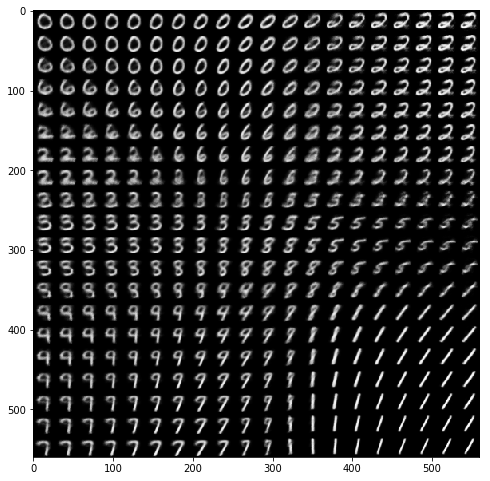

In [4]:
# Define VAE Loss
def vae_loss(x_reconstructed, x_true):
    # Reconstruction loss
    encode_decode_loss = x_true * tf.log(1e-10 + x_reconstructed) \
                         + (1 - x_true) * tf.log(1e-10 + 1 - x_reconstructed)
    encode_decode_loss = -tf.reduce_sum(encode_decode_loss, 1)
    # KL Divergence loss
    kl_div_loss = 1 + z_std - tf.square(z_mean) - tf.exp(z_std)
    kl_div_loss = -0.5 * tf.reduce_sum(kl_div_loss, 1)
    return tf.reduce_mean(encode_decode_loss + kl_div_loss)

loss_op = vae_loss(decoder, input_image)
optimizer = tf.train.RMSPropOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

# Start training
with tf.Session() as sess:

    # Run the initializer
    sess.run(init)

    for i in range(1, num_steps+1):
        # Prepare Data
        # Get the next batch of MNIST data (only images are needed, not labels)
        batch_x, _ = mnist.train.next_batch(batch_size)

        # Train
        feed_dict = {input_image: batch_x}
        _, l = sess.run([train_op, loss_op], feed_dict=feed_dict)
        if i % 1000 == 0 or i == 1:
            print('Step %i, Loss: %f' % (i, l))

    # Testing
    # Generator takes noise as input
    noise_input = tf.placeholder(tf.float32, shape=[None, latent_dim])
    # Rebuild the decoder to create image from noise
    decoder = tf.matmul(noise_input, weights['decoder_h1']) + biases['decoder_b1']
    decoder = tf.nn.tanh(decoder)
    decoder = tf.matmul(decoder, weights['decoder_out']) + biases['decoder_out']
    decoder = tf.nn.sigmoid(decoder)

    # Building a manifold of generated digits
    n = 20
    x_axis = np.linspace(-3, 3, n)
    y_axis = np.linspace(-3, 3, n)

    canvas = np.empty((28 * n, 28 * n))
    for i, yi in enumerate(x_axis):
        for j, xi in enumerate(y_axis):
            z_mu = np.array([[xi, yi]] * batch_size)
            x_mean = sess.run(decoder, feed_dict={noise_input: z_mu})
            canvas[(n - i - 1) * 28:(n - i) * 28, j * 28:(j + 1) * 28] = \
            x_mean[0].reshape(28, 28)

    plt.figure(figsize=(8, 10))
    Xi, Yi = np.meshgrid(x_axis, y_axis)
    plt.imshow(canvas, origin="upper", cmap="gray")
    plt.show()